# load data

In [1]:
import numpy as np

particle_data = np.load('data/particle_data.npy')
jet_data = np.load('data/jet_data.npy')
flavor_data = np.load('data/flavor_tags.npy')

# process data into training and test set

In [2]:
from sklearn.model_selection import train_test_split

X_particles_train, X_particles_test, X_jets_train, X_jets_test, y_train, y_test = train_test_split(
    particle_data, jet_data, flavor_data, test_size=0.1, random_state=42)

# Define model 

# Model 1
- nan issues in loss when training

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


# Define input shapes
num_particles = 50
num_constituent_features = 9
num_jet_features = 3

# hypperparams
l2_lambda = 0.001
lr = 0.0001

# Constituent-level input
particle_input = Input(shape=(num_particles, num_constituent_features), name='particle_input')

# Apply masking to ignore NaN values
masked_input = Masking(mask_value=np.nan)(particle_input)

# LSTM layers with L2 regularization
lstm_1 = LSTM(64, return_sequences=True, 
              kernel_regularizer=l2(l2_lambda), recurrent_regularizer=l2(l2_lambda), 
              activation='tanh', recurrent_activation='sigmoid')(masked_input)
lstm_2 = LSTM(32, 
              kernel_regularizer=l2(l2_lambda), recurrent_regularizer=l2(l2_lambda), 
              activation='tanh', recurrent_activation='sigmoid')(lstm_1)

# Jet-level input
jet_input = Input(shape=(num_jet_features,), name='jet_input')

# Concatenate LSTM output with jet-level input
concatenated = Concatenate()([lstm_2, jet_input])

# Dense layers with ReLU activation and L2 regularization
dense_1 = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(concatenated)
dense_2 = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(dense_1)


# Output layer (example with one output node for binary classification)
output = Dense(1, activation='sigmoid', name='output')(dense_2)

# Define the model
model = Model(inputs=[particle_input, jet_input], outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', metrics=[AUC(name='roc_auc')])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_roc_auc', 
                               patience=20, 
                               min_delta=0.0001, 
                               mode='max', 
                               restore_best_weights=True)

# Print the model summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particle_input (InputLayer  [(None, 50, 9)]              0         []                            
 )                                                                                                
                                                                                                  
 masking (Masking)           (None, 50, 9)                0         ['particle_input[0][0]']      
                                                                                                  
 lstm (LSTM)                 (None, 50, 64)               18944     ['masking[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['lstm[0][0]']          

# Model 2

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2

# Define input shapes
num_particles = 50
num_constituent_features = 9
num_jet_features = 3

# hyperparameters
lr = 0.0001
l2_lambda = 0.01 # This is causing loss to be nan.... 

# Constituent-level input
particle_input = Input(shape=(num_particles, num_constituent_features), name='particle_input')

# Apply masking to ignore NaN values
masked_input = Masking(mask_value=np.nan)(particle_input)

# LSTM layers with L2 regularization
lstm_1 = LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(masked_input)
lstm_2 = LSTM(32, activation='tanh', recurrent_activation='sigmoid')(lstm_1)

# Jet-level input
jet_input = Input(shape=(num_jet_features,), name='jet_input')

# Concatenate LSTM output with jet-level input
concatenated = Concatenate()([lstm_2, jet_input])

# Dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
dense_2 = Dense(32, activation='relu')(dense_1)

# Output layer (example with one output node for binary classification)
output = Dense(1, activation='sigmoid', name='output')(dense_2)

# Define the model
model = Model(inputs=[particle_input, jet_input], outputs=output)

# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[AUC(name='roc_auc')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particle_input (InputLayer  [(None, 50, 9)]              0         []                            
 )                                                                                                
                                                                                                  
 masking_9 (Masking)         (None, 50, 9)                0         ['particle_input[0][0]']      
                                                                                                  
 lstm_16 (LSTM)              (None, 50, 64)               18944     ['masking_9[0][0]']           
                                                                                                  
 lstm_17 (LSTM)              (None, 32)                   12416     ['lstm_16[0][0]']       

# Training

In [4]:
# Train the model
history = model.fit(
    [X_particles_train, X_jets_train], y_train,
    validation_split=0.2, 
    epochs=1000, 
    batch_size=1024)

Epoch 1/1000

12/33 [=========>....................] - ETA: 10s - loss: nan - roc_auc: 0.5000

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_particles_test, X_jets_test], y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

143/143 [==============================] - 5s 32ms/step - loss: 0.6510 - roc_auc: 0.5000
Test Loss: 0.650987446308136
Test Accuracy: 0.5


In [ ]:
history.history.keys()

dict_keys(['loss', 'roc_auc', 'val_loss', 'val_roc_auc'])

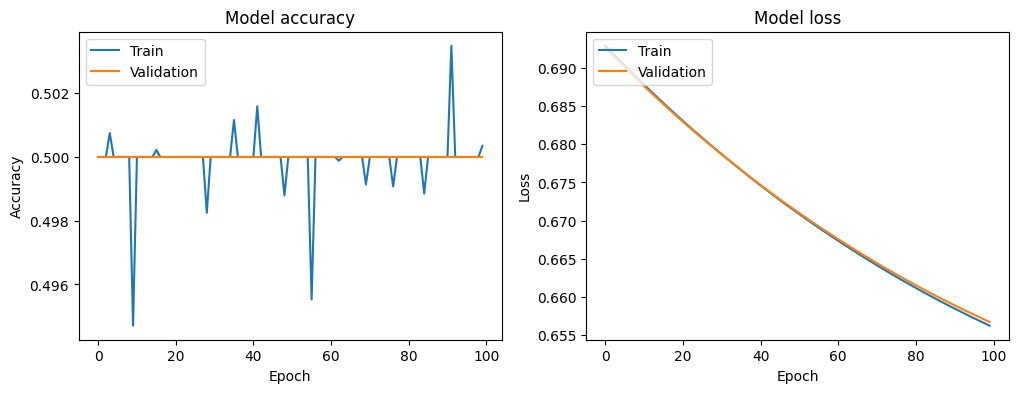

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()